In [ ]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using ASEconvert
using AtomsBase
using DFTK
using Plots
using PseudoPotentialData
using Random
DFTK.setup_threading(n_blas=1)

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


Status `~/git/tutorial-cecam-workshop-dftk-2025/Project.toml`
  [3da9722f] ASEconvert v0.2.0
  [a963bdd2] AtomsBase v0.5.2
  [1692102d] AtomsIO v0.3.0
  [ee286e10] AtomsView v0.1.5
  [acf6eb54] DFTK v0.7.18
  [6bd331d2] DftFunctionals v0.3.1
  [f6369f11] ForwardDiff v1.2.2
  [7073ff75] IJulia v1.31.1
  [91a5bcdd] Plots v1.41.1
  [5751a51d] PseudoPotentialData v0.2.4
  [6099a3de] PythonCall v0.9.28


┌ Info: Threading setup: 
│   Threads.nthreads() = 1
│   n_DFTK = 1
│   n_fft = 1
│   n_blas = 1
└ @ DFTK /home/schmitz/.julia/packages/DFTK/N6gvd/src/common/threading.jl:15


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order: the XC potential for the SCF solver, and
- second-order the XC kernel, used for DFPT.

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In [2]:
using DftFunctionals

"""
The BEEF ensemble is described by a Gaussian distribution
    in parameters θ ∼ N(θ_bf, LLᵀ)
    or equivalently: θ = θ_bf + L * α
    where α is standard normal.

From the paper:
    `Bayesian Error Estimation in Density-Functional Theory` (2005)
    J. J. Mortensen, K. Kaasbjerg, S. L. Frederiksen, J. K. Nørskov,
    J. P. Sethna, and K. W. Jacobsen
    DOI: https://doi.org/10.1103/PhysRevLett.95.216401
"""
function params_beef_2005()
    θ_bf = [1.0008, 0.1926, 1.8962]  # After Eq (4)
    L = [
        0.066 0.055 -0.034 
       -0.812 0.206  0.007 
        1.996 0.082  0.004
    ]  # Eq (5)
    (; θ_bf, L)
end

struct BeefExchange{T} <: Functional{:gga,:x} where {T}
    θ::T
    identifier::Symbol
end
BeefExchange(θ) = BeefExchange(θ, :gga_x_beef_custom)

DftFunctionals.parameters(beefx::BeefExchange) = beefx.θ
DftFunctionals.identifier(beefx::BeefExchange) = beefx.identifier

function DftFunctionals.change_parameters(beefx::BeefExchange, parameters::AbstractArray;
    keep_identifier=false)
    if keep_identifier
        BeefExchange(parameters, beefx.identifier)
    else
        BeefExchange(parameters)
    end
end

function f_x_beef(s, θ)
    sum(enumerate(θ)) do (i, θi)
        θi * (s / (one(s) + s))^(2i - 2)  # (3)
    end
end

function DftFunctionals.energy(beefx::BeefExchange, ρ::T, σ::U) where {T<:Number,U<:Number}
    TT = DftFunctionals.arithmetic_type(beefx, T, U)

    # s is the dimensionless electron density gradient
    # s = sqrt(σ) / (2kF * ρ)  # Above eq (2)
    s = sqrt(σ) / (ρ^(4 / 3) * 2cbrt(3π^2))
    
    θ = beefx.θ

    res = DftFunctionals.energy(LdaExchange(), ρ) * f_x_beef(s, θ)
    TT(res)
end

make_beef(θ) = [DftFunctional(Val(:gga_c_pbe)), BeefExchange(θ)]

make_beef (generic function with 1 method)

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

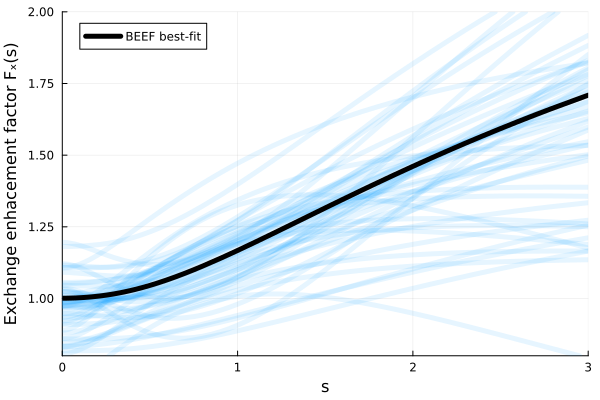

In [ ]:
let 
    params = params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [4]:
system = ase.build.bulk("Si")
system = pyconvert(AbstractSystem, system);

In [5]:
# functionals = PBE()
params = params_beef_2005()
functionals = make_beef(params.θ_bf)
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
temperature = 1e-3
model = model_DFT(system; pseudopotentials, functionals, temperature)

Ecut = recommended_cutoff(model).Ecut
kgrid = (4, 4, 4)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 1
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([4, 4, 4])
    num.   red. kpoints  : 64
    num. irred. kpoints  : 8

    Discretized Model(gga_c_pbe+gga_x_beef_custom, 3D):
        lattice (in Bohr)    : [0         , 5.13061   , 5.13061   ]
                               [5.13061   , 0         , 5.13061   ]
                               [5.13061   , 5.13061   , 0         ]
        unit cell volume     : 270.11 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.Sm

In [10]:
scfres = self_consistent_field(basis; tol=1e-5)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.443195437489                   -0.93    6.1    293ms
  2   -8.445218069806       -2.69       -1.41    1.0    260ms
  3   -8.445594985717       -3.42       -2.68    2.2    296ms
  4   -8.445616730320       -4.66       -3.73    3.5    328ms
  5   -8.445616809002       -7.10       -3.79    2.9    303ms
  6   -8.445616830883       -7.66       -4.35    2.5    285ms
  7   -8.445616831568       -9.16       -5.06    1.9    273ms


(ham = Hamiltonian(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([4, 4, 4])), HamiltonianBlock[DFTK.DftHamiltonianBlock(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([4, 4, 4])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), Any[DFTK.FourierMultiplication{Float64, Vector{Float64}}(PlaneWaveBasis(model = Model(gga_c_pbe+gga_x_beef_custom, spin_polarization = :none), Ecut = 18.0 Ha, kgrid = MonkhorstPack([4, 4, 4])), KPoint([     0,      0,      0], spin = 1, num. G vectors =   965), [0.0, 0.5624107360872233, 2.249642944348893, 5.061696624785009, 8.998571777395572, 14.06026840218058, 14.06026840218058, 8.998571777395572, 5.061696624785009, 2.249642944348893  …  2.062172698986485, 4.499285888697785, 8.061220550583531, 12.747976684643724, 16.49738159189188, 11.060744476382055, 6.748928833046679, 3.561934661885747, 

In [11]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             3.0909858 
    AtomicLocal         -2.3110105
    AtomicNonlocal      1.1489878 
    Ewald               -8.3994719
    PspCorrection       0.5534361 
    Hartree             0.5588454 
    Xc                  -3.0873895
    Entropy             -0.0000000

    total               -8.445616831568